In [156]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# Assignment
Familiarity with several pricing models and how to apply them to a portfolio. Now calculate the VWAP, Sharpe and Alpha for your portfolio from the start of the semester  to the date of you calculations. Your calculation results and the VaR calculations that you performed last week are the main content of the Portfolio Review presentation that is next week's subject and assignment. -- Remember Presentation is Important

# Variables

In [157]:
start_date = datetime(2022, 1, 1)
end_date = datetime.now()
alpha = 0.05
period = '10y'

# Functions

# Load Data

## Load Variables

In [158]:
var_lst = ['^TNX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
rf_rate = round((data.mean() / 100),4)
rf_rate

[*********************100%%**********************]  1 of 1 completed


0.0227

## Load Portfolio

In [159]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w5/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)

#folio_df = folio_df[4:]

portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

folio_df.head()

,Ticker,BondName,Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,"106,383.0000","1,000.0000",0.0119
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,"14,201.0000",500.0000,0.0060
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,"49,967.0000",750.0000,0.0090
3,C_A_S_H,Cash,Cash,"4,469,000.0000","4,469.0000",0.0534
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,"108,468.0000","2,250.0000",0.0269


In [160]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


In [161]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83719000.0

## Load Pricing Time Series

In [162]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']
price_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

price_df['C_A_S_H'] = 1
print('price_df #:', len(price_df.columns))

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No data found, symbol may be delisted')



price_df #: 35
return_df #: 35


In [163]:
print('ticker #:', len(ticker_lst))

ticker #: 35


In [164]:
price_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-07,9.9100,29.9600,20.9800,1,NaN,NaN,NaN,12.3600,NaN,6.9600,...,11.1900,89.8100,11.3300,NaN,22.4700,NaN,66.2000,102.4800,20.0075,NaN
2013-10-08,9.9100,29.4500,21.1800,1,NaN,NaN,NaN,12.2900,NaN,6.9600,...,11.1600,88.6100,11.3200,NaN,22.4600,NaN,65.4800,100.8200,19.6675,NaN
2013-10-09,9.9000,29.4700,21.3400,1,NaN,NaN,NaN,12.3500,NaN,6.9400,...,11.1700,88.3200,11.3100,NaN,22.4400,NaN,65.4900,100.7300,19.6300,NaN
2013-10-10,9.8800,30.1300,21.3500,1,NaN,NaN,NaN,12.5000,NaN,6.9500,...,11.1500,90.2700,11.3000,NaN,22.4200,NaN,67.1600,102.8200,20.0775,NaN
2013-10-11,9.8700,30.2200,21.3800,1,NaN,NaN,NaN,12.5300,NaN,6.9600,...,11.1500,91.3700,11.3100,NaN,22.4500,NaN,67.8300,103.4800,20.2275,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,9.1700,33.9900,14.8200,1,19.5200,22.7500,32.2700,19.4700,10.5600,5.8900,...,9.8900,159.4900,9.5900,17.9500,20.4400,71.3300,75.6600,208.2400,68.4400,48.1000
2023-10-02,9.1400,33.8400,14.7800,1,19.1800,22.3300,31.8820,19.4700,10.5400,5.8400,...,9.8200,156.9400,9.5400,17.8600,20.2800,70.5500,74.2700,205.8000,69.0300,47.7100
2023-10-03,9.1100,33.6300,14.7000,1,18.8100,21.8900,31.4580,19.2900,10.4500,5.7900,...,9.7600,154.4600,9.4900,17.7400,20.1100,69.8800,72.8200,202.9400,67.8000,47.5700


In [165]:
return_df = return_df[1:]
return_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-08,0.0000,-0.0170,0.0095,0.0000,NaN,NaN,NaN,-0.0057,NaN,0.0000,...,-0.0027,-0.0134,-0.0009,NaN,-0.0004,NaN,-0.0109,-0.0162,-0.0170,NaN
2013-10-09,-0.0010,0.0007,0.0076,0.0000,NaN,NaN,NaN,0.0049,NaN,-0.0029,...,0.0009,-0.0033,-0.0009,NaN,-0.0009,NaN,0.0002,-0.0009,-0.0019,NaN
2013-10-10,-0.0020,0.0224,0.0005,0.0000,NaN,NaN,NaN,0.0121,NaN,0.0014,...,-0.0018,0.0221,-0.0009,NaN,-0.0009,NaN,0.0255,0.0207,0.0228,NaN
2013-10-11,-0.0010,0.0030,0.0014,0.0000,NaN,NaN,NaN,0.0024,NaN,0.0014,...,0.0000,0.0122,0.0009,NaN,0.0013,NaN,0.0100,0.0064,0.0075,NaN
2013-10-14,-0.0010,0.0030,0.0000,0.0000,NaN,NaN,NaN,0.0032,NaN,-0.0029,...,0.0000,0.0039,-0.0018,NaN,-0.0018,NaN,0.0006,0.0038,0.0023,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0.0022,-0.0038,-0.0074,0.0000,0.0021,0.0026,-0.0051,0.0000,0.0000,0.0000,...,-0.0110,-0.0036,0.0000,-0.0105,-0.0034,-0.0039,0.0029,-0.0030,-0.0006,0.0015
2023-10-02,-0.0033,-0.0044,-0.0027,0.0000,-0.0174,-0.0185,-0.0120,0.0000,-0.0019,-0.0085,...,-0.0071,-0.0160,-0.0052,-0.0050,-0.0078,-0.0109,-0.0184,-0.0117,0.0086,-0.0081
2023-10-03,-0.0033,-0.0062,-0.0054,0.0000,-0.0193,-0.0197,-0.0133,-0.0092,-0.0085,-0.0086,...,-0.0061,-0.0158,-0.0052,-0.0067,-0.0084,-0.0095,-0.0195,-0.0139,-0.0178,-0.0029


## Analytics

return_df.corr()

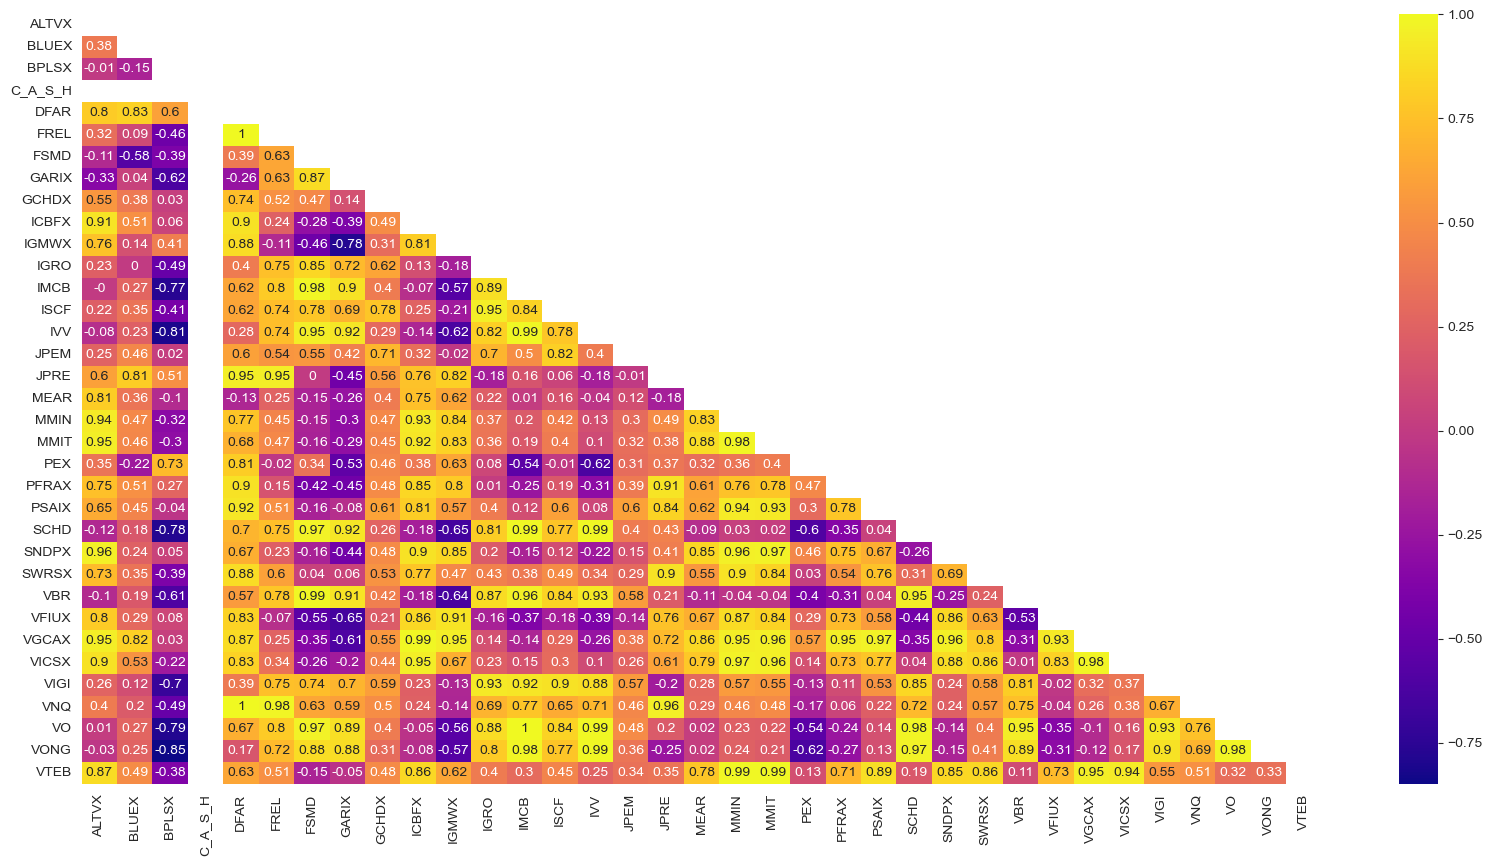

In [166]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

# VaR Calculation

#Generate Var-Cov matrix
cov_matrix = return_df.cov()
cov_matrix

#Calculate mean returns for each stock
avg_ret_df = return_df.mean()

#Calculate mean returns for portfolio overall,
#using mean, using dot product formula to
#normalize against investment weights
port_mean = avg_ret_df.dot(weight_lst)

#Calculate portfolio standard deviation
port_stdev = np.sqrt(weight_lst.T.dot(cov_matrix).dot(weight_lst))

#Calculate mean of given investment
mean_investment = (1+port_mean) * initial_investment

#Calculate standard deviation of given investmnet
stdev_investment = initial_investment * port_stdev

## Calculate the inverse of the normal cumulative distribution (PPF)

#Using SciPy ppf method to generate values for the inverse cumulative distribution function to a normal distribution
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(alpha, mean_investment, stdev_investment)

#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

## Value at risk over n-day time period

# Calculate n Day VaR
var_array = []
num_days = int(30)
for x in range(1, num_days+1):
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")

# Sharpe Calculation 

In [167]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
port_ret_weighted

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-08,0.0000,-0.0001,0.0001,0.0000,NaN,NaN,NaN,-0.0000,NaN,0.0000,...,-0.0002,-0.0002,-0.0001,NaN,-0.0000,NaN,-0.0004,-0.0004,-0.0006,NaN
2013-10-09,-0.0000,0.0000,0.0001,0.0000,NaN,NaN,NaN,0.0000,NaN,-0.0000,...,0.0001,-0.0000,-0.0001,NaN,-0.0000,NaN,0.0000,-0.0000,-0.0001,NaN
2013-10-10,-0.0000,0.0001,0.0000,0.0000,NaN,NaN,NaN,0.0001,NaN,0.0000,...,-0.0001,0.0003,-0.0001,NaN,-0.0000,NaN,0.0010,0.0005,0.0008,NaN
2013-10-11,-0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,NaN,0.0000,...,0.0000,0.0001,0.0001,NaN,0.0000,NaN,0.0004,0.0002,0.0003,NaN
2013-10-14,-0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,NaN,-0.0000,...,0.0000,0.0000,-0.0001,NaN,-0.0000,NaN,0.0000,0.0001,0.0001,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0.0000,-0.0000,-0.0001,0.0000,0.0001,0.0001,-0.0002,0.0000,0.0000,0.0000,...,-0.0008,-0.0000,0.0000,-0.0001,-0.0001,-0.0001,0.0001,-0.0001,-0.0000,0.0000
2023-10-02,-0.0000,-0.0000,-0.0000,0.0000,-0.0005,-0.0006,-0.0006,0.0000,-0.0000,-0.0001,...,-0.0005,-0.0002,-0.0003,-0.0001,-0.0002,-0.0004,-0.0007,-0.0003,0.0003,-0.0001
2023-10-03,-0.0000,-0.0000,-0.0000,0.0000,-0.0005,-0.0007,-0.0006,-0.0001,-0.0001,-0.0001,...,-0.0004,-0.0002,-0.0003,-0.0001,-0.0002,-0.0003,-0.0008,-0.0003,-0.0006,-0.0000


In [168]:
return_df['Portfolio']= port_ret_weighted.sum(axis=1).dropna()
return_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB,Portfolio
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-08,0.0000,-0.0170,0.0095,0.0000,NaN,NaN,NaN,-0.0057,NaN,0.0000,...,-0.0134,-0.0009,NaN,-0.0004,NaN,-0.0109,-0.0162,-0.0170,NaN,-0.0039
2013-10-09,-0.0010,0.0007,0.0076,0.0000,NaN,NaN,NaN,0.0049,NaN,-0.0029,...,-0.0033,-0.0009,NaN,-0.0009,NaN,0.0002,-0.0009,-0.0019,NaN,-0.0006
2013-10-10,-0.0020,0.0224,0.0005,0.0000,NaN,NaN,NaN,0.0121,NaN,0.0014,...,0.0221,-0.0009,NaN,-0.0009,NaN,0.0255,0.0207,0.0228,NaN,0.0051
2013-10-11,-0.0010,0.0030,0.0014,0.0000,NaN,NaN,NaN,0.0024,NaN,0.0014,...,0.0122,0.0009,NaN,0.0013,NaN,0.0100,0.0064,0.0075,NaN,0.0028
2013-10-14,-0.0010,0.0030,0.0000,0.0000,NaN,NaN,NaN,0.0032,NaN,-0.0029,...,0.0039,-0.0018,NaN,-0.0018,NaN,0.0006,0.0038,0.0023,NaN,0.0007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0.0022,-0.0038,-0.0074,0.0000,0.0021,0.0026,-0.0051,0.0000,0.0000,0.0000,...,-0.0036,0.0000,-0.0105,-0.0034,-0.0039,0.0029,-0.0030,-0.0006,0.0015,-0.0014
2023-10-02,-0.0033,-0.0044,-0.0027,0.0000,-0.0174,-0.0185,-0.0120,0.0000,-0.0019,-0.0085,...,-0.0160,-0.0052,-0.0050,-0.0078,-0.0109,-0.0184,-0.0117,0.0086,-0.0081,-0.0089
2023-10-03,-0.0033,-0.0062,-0.0054,0.0000,-0.0193,-0.0197,-0.0133,-0.0092,-0.0085,-0.0086,...,-0.0158,-0.0052,-0.0067,-0.0084,-0.0095,-0.0195,-0.0139,-0.0178,-0.0029,-0.0107


In [169]:
tickers='NIFTYBEES.NS'
NIFTY50 = pdr.get_data_yahoo(tickers=tickers, period=period)
return_df['Benchmark']= NIFTY50['Close']
return_df['Benchmark']= return_df['Benchmark'].pct_change(1) #.dropna()
#return_df= return_df.dropna()
return_df

[*********************100%%**********************]  1 of 1 completed


,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB,Portfolio,Benchmark
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-08,0.0000,-0.0170,0.0095,0.0000,NaN,NaN,NaN,-0.0057,NaN,0.0000,...,-0.0009,NaN,-0.0004,NaN,-0.0109,-0.0162,-0.0170,NaN,-0.0039,NaN
2013-10-09,-0.0010,0.0007,0.0076,0.0000,NaN,NaN,NaN,0.0049,NaN,-0.0029,...,-0.0009,NaN,-0.0009,NaN,0.0002,-0.0009,-0.0019,NaN,-0.0006,0.0099
2013-10-10,-0.0020,0.0224,0.0005,0.0000,NaN,NaN,NaN,0.0121,NaN,0.0014,...,-0.0009,NaN,-0.0009,NaN,0.0255,0.0207,0.0228,NaN,0.0051,0.0004
2013-10-11,-0.0010,0.0030,0.0014,0.0000,NaN,NaN,NaN,0.0024,NaN,0.0014,...,0.0009,NaN,0.0013,NaN,0.0100,0.0064,0.0075,NaN,0.0028,0.0099
2013-10-14,-0.0010,0.0030,0.0000,0.0000,NaN,NaN,NaN,0.0032,NaN,-0.0029,...,-0.0018,NaN,-0.0018,NaN,0.0006,0.0038,0.0023,NaN,0.0007,0.0027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0.0022,-0.0038,-0.0074,0.0000,0.0021,0.0026,-0.0051,0.0000,0.0000,0.0000,...,0.0000,-0.0105,-0.0034,-0.0039,0.0029,-0.0030,-0.0006,0.0015,-0.0014,0.0045
2023-10-02,-0.0033,-0.0044,-0.0027,0.0000,-0.0174,-0.0185,-0.0120,0.0000,-0.0019,-0.0085,...,-0.0052,-0.0050,-0.0078,-0.0109,-0.0184,-0.0117,0.0086,-0.0081,-0.0089,0.0000
2023-10-03,-0.0033,-0.0062,-0.0054,0.0000,-0.0193,-0.0197,-0.0133,-0.0092,-0.0085,-0.0086,...,-0.0052,-0.0067,-0.0084,-0.0095,-0.0195,-0.0139,-0.0178,-0.0029,-0.0107,-0.0054


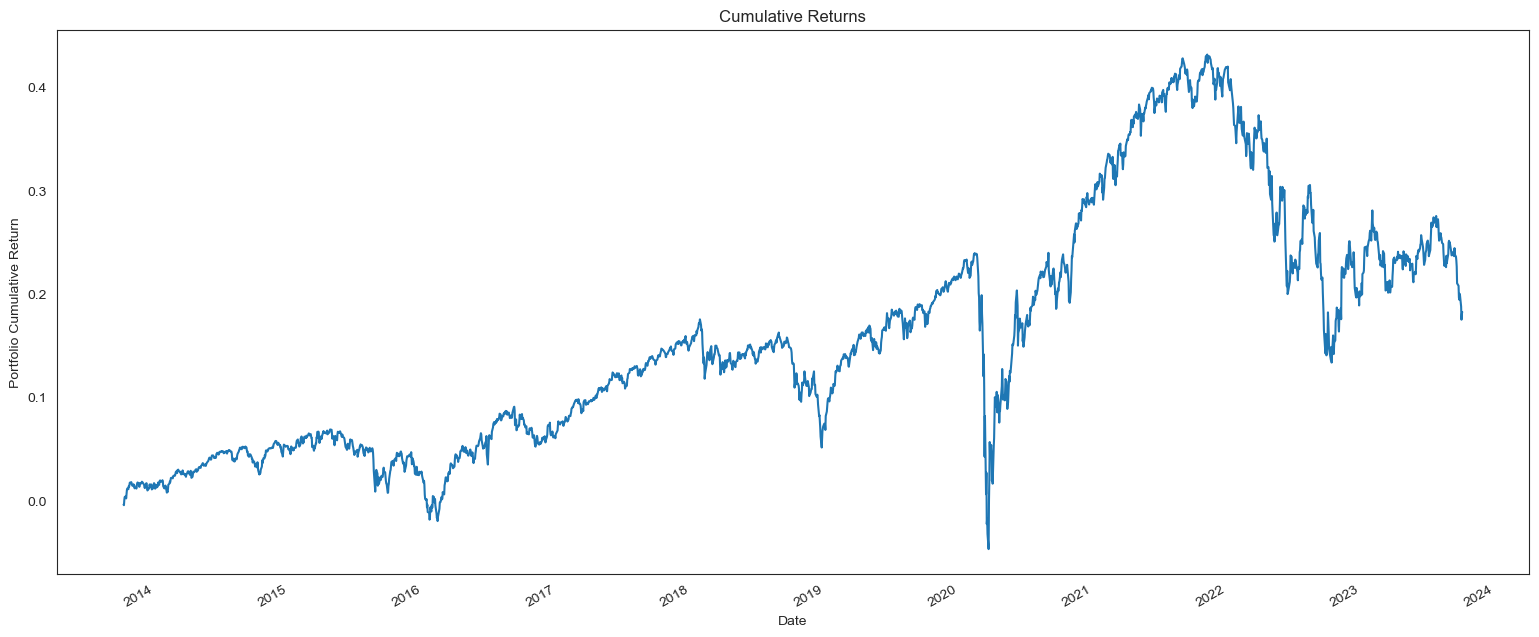

In [170]:
cum_ret_port = ((1 + return_df['Portfolio']).cumprod()-1)
cum_ret_port.plot(label='Cumulative Returns of the Portfolio' ,figsize=(19,8),title='Cumulative Returns')
_=plt.xlabel('Date' )
_=plt.ylabel('Portfolio Cumulative Return' )

In [171]:
port_bench = pd.concat([return_df['Portfolio' ],return_df['Benchmark' ]],axis=1 ).dropna()
port_bench.columns=['Portfolio',' Benchmark' ]
correlation=port_bench.corr()
correlation

,Portfolio,Benchmark
Portfolio,1.0000,0.0120
Benchmark,0.0120,1.0000


In [172]:
return_df['RF Rate']= rf_rate
return_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB,Portfolio,Benchmark,RF Rate
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-08,0.0000,-0.0170,0.0095,0.0000,NaN,NaN,NaN,-0.0057,NaN,0.0000,...,NaN,-0.0004,NaN,-0.0109,-0.0162,-0.0170,NaN,-0.0039,NaN,0.0227
2013-10-09,-0.0010,0.0007,0.0076,0.0000,NaN,NaN,NaN,0.0049,NaN,-0.0029,...,NaN,-0.0009,NaN,0.0002,-0.0009,-0.0019,NaN,-0.0006,0.0099,0.0227
2013-10-10,-0.0020,0.0224,0.0005,0.0000,NaN,NaN,NaN,0.0121,NaN,0.0014,...,NaN,-0.0009,NaN,0.0255,0.0207,0.0228,NaN,0.0051,0.0004,0.0227
2013-10-11,-0.0010,0.0030,0.0014,0.0000,NaN,NaN,NaN,0.0024,NaN,0.0014,...,NaN,0.0013,NaN,0.0100,0.0064,0.0075,NaN,0.0028,0.0099,0.0227
2013-10-14,-0.0010,0.0030,0.0000,0.0000,NaN,NaN,NaN,0.0032,NaN,-0.0029,...,NaN,-0.0018,NaN,0.0006,0.0038,0.0023,NaN,0.0007,0.0027,0.0227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0.0022,-0.0038,-0.0074,0.0000,0.0021,0.0026,-0.0051,0.0000,0.0000,0.0000,...,-0.0105,-0.0034,-0.0039,0.0029,-0.0030,-0.0006,0.0015,-0.0014,0.0045,0.0227
2023-10-02,-0.0033,-0.0044,-0.0027,0.0000,-0.0174,-0.0185,-0.0120,0.0000,-0.0019,-0.0085,...,-0.0050,-0.0078,-0.0109,-0.0184,-0.0117,0.0086,-0.0081,-0.0089,0.0000,0.0227
2023-10-03,-0.0033,-0.0062,-0.0054,0.0000,-0.0193,-0.0197,-0.0133,-0.0092,-0.0085,-0.0086,...,-0.0067,-0.0084,-0.0095,-0.0195,-0.0139,-0.0178,-0.0029,-0.0107,-0.0054,0.0227


In [173]:
return_df['excess_b' ]= return_df['Benchmark' ] - return_df['RF Rate' ]

In [175]:
sharpe_ratio=((return_df['Portfolio' ].mean() - return_df['RF Rate'].mean()))/return_df['Portfolio' ].std()
round(sharpe_ratio,4)

-4.0832